In [1]:
#Code template from Lazy Programmer CNN course
from __future__ import print_function, division
from builtins import range, input

from keras.layers import Input, Lambda, Dense, Flatten
from keras.layers import AveragePooling2D, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image

import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import fmin_l_bfgs_b

Using TensorFlow backend.


# Generating image capturing main features

iter=0, loss=139.16802978515625
iter=1, loss=55.66890335083008
iter=2, loss=30.52790641784668
iter=3, loss=20.082157135009766
iter=4, loss=15.122624397277832
iter=5, loss=12.029377937316895
iter=6, loss=10.038020133972168
iter=7, loss=8.62962818145752
iter=8, loss=7.595907688140869
iter=9, loss=6.784404754638672
duration: 0:00:14.363821


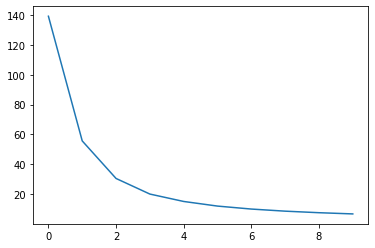

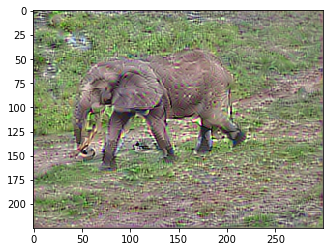

In [10]:
def VGG16_AvgPool(shape):
  # we want to account for features across the entire image
  # so get rid of the maxpool which throws away information
  vgg = VGG16(input_shape=shape, weights='imagenet', include_top=False)

  new_model = Sequential()
  for layer in vgg.layers:
    if layer.__class__ == MaxPooling2D:
      # replace it with average pooling
      new_model.add(AveragePooling2D())
    else:
      new_model.add(layer)

  return new_model

def VGG16_AvgPool_CutOff(shape, num_convs):
  # there are 13 convolutions in total
  # we can pick any of them as the "output"
  # of our content model

  if num_convs < 1 or num_convs > 13:
    print("num_convs must be in the range [1, 13]")
    return None

  model = VGG16_AvgPool(shape)
  new_model = Sequential()
  n = 0
  for layer in model.layers:
    if layer.__class__ == Conv2D:
      n += 1
    new_model.add(layer)
    if n >= num_convs:
      break

  return new_model


def unpreprocess(img):
  img[..., 0] += 103.939
  img[..., 1] += 116.779
  img[..., 2] += 126.68
  img = img[..., ::-1]
  return img


def scale_img(x):
  x = x - x.min()
  x = x / x.max()
  return x


if __name__ == '__main__':

  # open an image
  # feel free to try your own
  # path = '../large_files/caltech101/101_ObjectCategories/elephant/image_0002.jpg'
  path = 'content/elephant.jpg'
  img = image.load_img(path)

  # convert image to array and preprocess for vgg
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  # we'll use this throughout the rest of the script
  batch_shape = x.shape
  shape = x.shape[1:]

  # see the image
  # plt.imshow(img)
  # plt.show()


  # make a content model
  # try different cutoffs to see the images that result
  content_model = VGG16_AvgPool_CutOff(shape, 10)

  # make the target
  target = K.variable(content_model.predict(x))


  # try to match the image

  # define our loss in keras
  loss = K.mean(K.square(target - content_model.output))

  # gradients which are needed by the optimizer
  grads = K.gradients(loss, content_model.input)

  # just like theano.function
  get_loss_and_grads = K.function(
    inputs=[content_model.input],
    outputs=[loss] + grads
  )


  def get_loss_and_grads_wrapper(x_vec):
    # scipy's minimizer allows us to pass back
    # function value f(x) and its gradient f'(x)
    # simultaneously, rather than using the fprime arg
    #
    # we cannot use get_loss_and_grads() directly
    # input to minimizer func must be a 1-D array
    # input to get_loss_and_grads must be [batch_of_images]
    #
    # gradient must also be a 1-D array
    # and both loss and gradient must be np.float64
    # will get an error otherwise

    l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)



  from datetime import datetime
  t0 = datetime.now()
  losses = []
  x = np.random.randn(np.prod(batch_shape))
  for i in range(10):
    x, l, _ = fmin_l_bfgs_b(
      func=get_loss_and_grads_wrapper,
      x0=x,
      # bounds=[[-127, 127]]*len(x.flatten()),
      maxfun=20
    )
    x = np.clip(x, -127, 127)
    # print("min:", x.min(), "max:", x.max())
    print("iter=%s, loss=%s" % (i, l))
    losses.append(l)

  print("duration:", datetime.now() - t0)
  plt.plot(losses)
  plt.show()

  newimg = x.reshape(*batch_shape)
  final_img = unpreprocess(newimg)


  plt.imshow(scale_img(final_img[0]))
  plt.show()

# Generating image with the same style

iter=0, loss=9639.56640625
iter=1, loss=338.0040588378906
iter=2, loss=154.4180450439453
iter=3, loss=98.15555572509766
iter=4, loss=74.4453353881836
iter=5, loss=55.71696090698242
iter=6, loss=41.454288482666016
iter=7, loss=31.240758895874023
iter=8, loss=23.2521915435791
iter=9, loss=17.7979679107666
duration: 0:00:33.465914


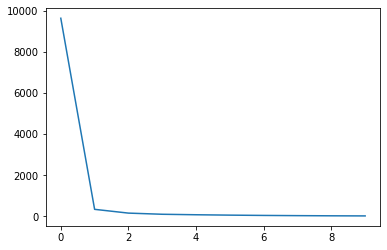

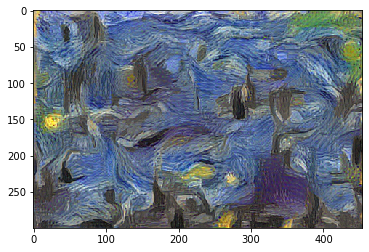

In [5]:

def gram_matrix(img):
  # input is (H, W, C) (C = # feature maps)
  # we first need to convert it to (C, H*W)
  X = K.batch_flatten(K.permute_dimensions(img, (2, 0, 1)))
  
  # now, calculate the gram matrix
  # gram = XX^T / N
  # the constant is not important since we'll be weighting these
  G = K.dot(X, K.transpose(X)) / img.get_shape().num_elements()
  return G


def style_loss(y, t):
  return K.mean(K.square(gram_matrix(y) - gram_matrix(t)))


# let's generalize this and put it into a function
def minimize(fn, epochs, batch_shape):
  t0 = datetime.now()
  losses = []
  x = np.random.randn(np.prod(batch_shape))
  for i in range(epochs):
    x, l, _ = fmin_l_bfgs_b(
      func=fn,
      x0=x,
      maxfun=20
    )
    x = np.clip(x, -127, 127)
    print("iter=%s, loss=%s" % (i, l))
    losses.append(l)

  print("duration:", datetime.now() - t0)
  plt.plot(losses)
  plt.show()

  newimg = x.reshape(*batch_shape)
  final_img = unpreprocess(newimg)
  return final_img[0]


if __name__ == '__main__':
  # try these, or pick your own!
  path = 'styles/starrynight.jpg'
  # path = 'styles/flowercarrier.jpg'
  # path = 'styles/monalisa.jpg'
  # path = 'styles/lesdemoisellesdavignon.jpg'


  # load the data
  img = image.load_img(path)

  # convert image to array and preprocess for vgg
  x = image.img_to_array(img)

  # look at the image
  # plt.imshow(x)
  # plt.show()

  # make it (1, H, W, C)
  x = np.expand_dims(x, axis=0)

  # preprocess into VGG expected format
  x = preprocess_input(x)

  # we'll use this throughout the rest of the script
  batch_shape = x.shape
  shape = x.shape[1:]

  # let's take the first convolution at each block of convolutions
  # to be our target outputs
  # remember that you can print out the model summary if you want
  vgg = VGG16_AvgPool(shape)

  # Note: need to select output at index 1, since outputs at
  # index 0 correspond to the original vgg with maxpool
  symbolic_conv_outputs = [
    layer.get_output_at(1) for layer in vgg.layers \
    if layer.name.endswith('conv1')
  ]

  # pick the earlier layers for
  # a more "localized" representation
  # this is opposed to the content model
  # where the later layers represent a more "global" structure
  # symbolic_conv_outputs = symbolic_conv_outputs[:2]

  # make a big model that outputs multiple layers' outputs
  multi_output_model = Model(vgg.input, symbolic_conv_outputs)

  # calculate the targets that are output at each layer
  style_layers_outputs = [K.variable(y) for y in multi_output_model.predict(x)]

  # calculate the total style loss
  loss = 0
  for symbolic, actual in zip(symbolic_conv_outputs, style_layers_outputs):
    # gram_matrix() expects a (H, W, C) as input
    loss += style_loss(symbolic[0], actual[0])

  grads = K.gradients(loss, multi_output_model.input)

  # just like theano.function
  get_loss_and_grads = K.function(
    inputs=[multi_output_model.input],
    outputs=[loss] + grads
  )


  def get_loss_and_grads_wrapper(x_vec):
    l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)


  final_img = minimize(get_loss_and_grads_wrapper, 10, batch_shape)
  plt.imshow(scale_img(final_img))
  plt.show()

# Generating image with style from another image

iter=0, loss=5675.39794921875
iter=1, loss=1288.0142822265625
iter=2, loss=797.4696655273438
iter=3, loss=600.944091796875
iter=4, loss=497.94854736328125
iter=5, loss=433.7854309082031
iter=6, loss=393.39068603515625
iter=7, loss=364.5343017578125
iter=8, loss=343.6098937988281
iter=9, loss=327.6040344238281
duration: 0:00:56.485231


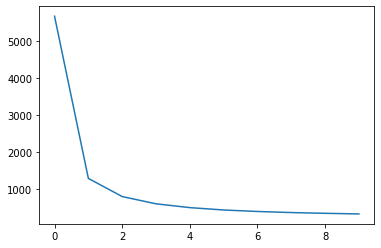

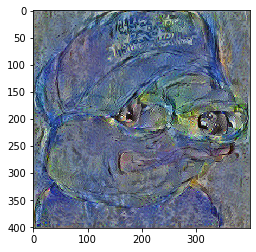

In [14]:
# load the content image
def load_img_and_preprocess(path, shape=None):
  img = image.load_img(path, target_size=shape)

  # convert image to array and preprocess for vgg
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  return x



content_img = load_img_and_preprocess(
  # '../large_files/caltech101/101_ObjectCategories/elephant/image_0002.jpg',
  # 'batman.jpg',
  #'content/sydney.jpg',
  # (225, 300),
    'content/pepe.jpg'
)

# resize the style image
# since we don't care too much about warping it
h, w = content_img.shape[1:3]
style_img = load_img_and_preprocess(
   'styles/starrynight.jpg',
  # 'styles/flowercarrier.jpg',
  # 'styles/monalisa.jpg',
  #'styles/lesdemoisellesdavignon.jpg',
  (h, w)
)


# we'll use this throughout the rest of the script
batch_shape = content_img.shape
shape = content_img.shape[1:]


# we want to make only 1 VGG here
# as you'll see later, the final model needs
# to have a common input
vgg = VGG16_AvgPool(shape)


# create the content model
# we only want 1 output
# remember you can call vgg.summary() to see a list of layers
# 1,2,4,5,7-9,11-13,15-17
content_model = Model(vgg.input, vgg.layers[14].get_output_at(0))
content_target = K.variable(content_model.predict(content_img))


# create the style model
# we want multiple outputs
# we will take the same approach as in style_transfer2.py
symbolic_conv_outputs = [
  layer.get_output_at(1) for layer in vgg.layers \
  if layer.name.endswith('conv1')
]

# make a big model that outputs multiple layers' outputs
style_model = Model(vgg.input, symbolic_conv_outputs)

# calculate the targets that are output at each layer
style_layers_outputs = [K.variable(y) for y in style_model.predict(style_img)]

# we will assume the weight of the content loss is 1
# and only weight the style losses
style_weights = [0.2,0.4,0.3,0.5,0.2]



# create the total loss which is the sum of content + style loss
loss = K.mean(K.square(content_model.output - content_target))

for w, symbolic, actual in zip(style_weights, symbolic_conv_outputs, style_layers_outputs):
  # gram_matrix() expects a (H, W, C) as input
  loss += w * style_loss(symbolic[0], actual[0])


# once again, create the gradients and loss + grads function
# note: it doesn't matter which model's input you use
# they are both pointing to the same keras Input layer in memory
grads = K.gradients(loss, vgg.input)

# just like theano.function
get_loss_and_grads = K.function(
  inputs=[vgg.input],
  outputs=[loss] + grads
)


def get_loss_and_grads_wrapper(x_vec):
  l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
  return l.astype(np.float64), g.flatten().astype(np.float64)


final_img = minimize(get_loss_and_grads_wrapper, 10, batch_shape)
plt.imshow(scale_img(final_img))
plt.show()